In [45]:
import os
import torch
import torchvision
import cv2
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import albumentations as A
from torchsummary import summary
from PIL import Image
from albumentations.pytorch.transforms import ToTensor
from tqdm import tqdm

##Setting the device

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Architecture

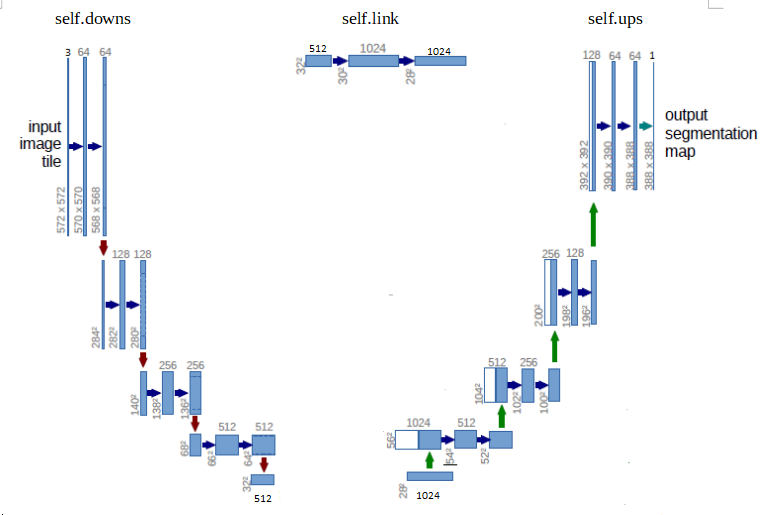

## Network

In [6]:
#torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
#torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
#torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

class DoubleConv(nn.Module):

  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, 1),
                              nn.ReLU(),
                              nn.Conv2d(out_channels, out_channels, 3, 1),   
                              nn.ReLU()) 
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):

  def __init__(self, in_channels=3, out_channels=1, filters=[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.link = DoubleConv(filters[-1], filters[-1]*2)

    for n_filters in filters:
      self.downs.append(DoubleConv(in_channels, n_filters))
      self.downs.append(nn.MaxPool2d(2, 2))
      in_channels = n_filters
    
    for n_filters in reversed(filters):
      self.ups.append(nn.ConvTranspose2d(n_filters*2, n_filters, 2, 2))
      self.ups.append(DoubleConv(n_filters*2, n_filters))   
    self.ups.append(nn.Conv2d(filters[0], out_channels, 1))
    
  def forward(self, x):
    skip_conctns = []
    
    for idx, down in enumerate(self.downs):
      x = down(x)
      if idx%2 == 0:
        skip_conctns.append(x)
        
    x = self.link(x)
    skip_conctns = skip_conctns[::-1]
    
    for idx in range(0, len(self.ups)-1, 2):
      x = self.ups[idx](x)
      skip_conctn = skip_conctns[idx//2]
      
      if skip_conctn.shape != x.shape:
        skip_conctn = torchvision.transforms.functional.resize(skip_conctn, size=x.shape[2:])
        
      concat = torch.cat((skip_conctn,x), dim=1)
      x = self.ups[idx+1](concat)
        
    return nn.Sigmoid()(self.ups[-1](x))

## Custom Dataset

In [7]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, img_dir, msk_dir):
    self.img_dir = img_dir
    self.msk_dir = msk_dir
    self.images = os.listdir(img_dir)
      
  def __len__(self):
    return len(self.images)
      
  def __getitem__(self, idx):
    img_pth = os.path.join(self.img_dir, self.images[idx])
    msk_pth = os.path.join(self.msk_dir, self.images[idx].replace('.jpg','_mask.gif'))
    image = torchvision.io.read_image(img_pth)
    image = torchvision.transforms.Resize((240,360))(image)
    image = image/255.0
    mask = torch.tensor(np.array(Image.open(msk_pth).convert('L').resize((164,52)),dtype=np.float32))
    mask = mask/255.0
    mask = mask.unsqueeze(0)

    return image, mask

In [8]:
def save_chkpt(model, optim, filename='drive/MyDrive/UNet.pth.tar'):
  chkpt = {'model':model.state_dict(),'optim':optim.state_dict()}
  torch.save(chkpt, filename)

def load_chkpt(model, optim, filename='drive/MyDrive/UNet.pth.tar'):
  chkpt = torch.load(filename)
  model.load_state_dict(chkpt['model'])
  optim.load_state_dict(chkpt['optim'])

In [9]:
epoch_losses = [] 
def train(x_train, y_train, model, optim, loss_fn, epochs):
  train_set = Dataset(x_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_set, 16, True)
  for epoch in range(epochs):
    batch_losses = []
    if epoch%1==0 and epoch!=0:
      save_chkpt(model, optim)
    loop = tqdm(train_loader,  position=0, leave=True)
    for x, y in loop:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      batch_losses.append(loss.item())
      optim.zero_grad()
      loss.backward()
      optim.step()
      loop.set_postfix(loss=loss)

    epoch_losses.append(sum(batch_losses)/len(batch_losses))
  return

In [10]:
model = UNet()
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
train('drive/MyDrive/train','drive/MyDrive/train_masks',model,optim,loss_fn,10)   

100%|██████████| 318/318 [04:52<00:00,  1.09it/s, loss=tensor(0.0309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)]


In [11]:
load_chkpt(model, optim)

In [81]:
def test(img_pth, model):
  orig_image = torchvision.io.read_image(img_pth)
  height, width = orig_image.shape[1], orig_image.shape[2]
  image = torchvision.transforms.Resize((240,360))(orig_image)
  image = image/255.0
  mask_pred = model(image.unsqueeze(0))
  mask_pred = torchvision.transforms.Resize((height, width))(mask_pred[0,:,:] * 255.0).squeeze(0)
  mask_pred = np.array(mask_pred.detach().numpy(),np.uint8)
  mask = np.zeros((height, width, 3),np.uint8)
  mask[:,:,0] = mask_pred
  orig_image = np.array(orig_image.permute(1,2,0))
  plt.imshow(cv2.addWeighted(orig_image,0.8,mask,1,1))
  return

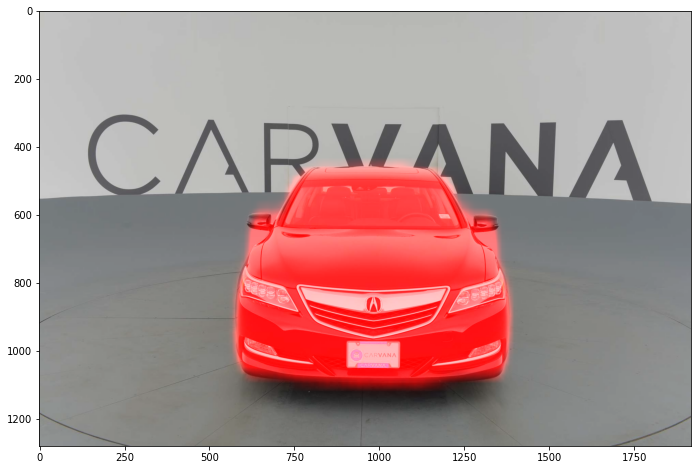

In [82]:
test('drive/MyDrive/train/00087a6bd4dc_01.jpg',model)